# Name(s)
**Ethan Moore and Ajay Patel**

## Should we grade this notebook? (Answer yes or no)

YES

**Instructions:** Pair programming assignment. Submit only a single notebook unless you deviate significantly after lab on Thursday. If you submit individually, make sure you indicate who you worked with originally. Make sure to include your first and last names. For those students who push to individual repos but still work in groups, please indicate which notebook should be graded.

# Ensemble Learning and Perceptron

## Lab Assignment

This is a pair programming assignment. I strongly
discourage individual work for this (and other team/pair programming) lab(s), even if you think you can do it
all by yourself. Also, this is a pair programming assignment, not a ”work in teams of two” assignment. Pair
programming requires joint work on all aspects of the project without delegating portions of the work to individual
1
team members. For this lab, I want all your work — discussion, software development, analysis of the results,
report writing — to be products of joint work.
Students enrolled in the class can pair with other students enrolled in the class. Students on the waitlist can
pair with other students on the waitlists. In the cases of ”odd person out” situations, a team of three people can
be formed, but that team must (a) ask and answer one additional question, and (b) work as a pair would, without
delegation of any work off-line.

## At the end of this lab, I should be able to
* Formulate your own questions and understand how you can go about getting answers
* Understand how to select an algorithm for your task
* Implement ensemble methods gradient boosting and random forest

## Our data
We will be using a well known housing dataset from Boston.
<pre>
The Boston house-price data of Harrison, D. and Rubinfeld, D.L. 'Hedonic
 prices and the demand for clean air', J. Environ. Economics & Management,
 vol.5, 81-102, 1978.   Used in Belsley, Kuh & Welsch, 'Regression diagnostics
 ...', Wiley, 1980.   N.B. Various transformations are used in the table on
 pages 244-261 of the latter.

 Variables in order:
 CRIM     per capita crime rate by town
 ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
 INDUS    proportion of non-retail business acres per town
 CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
 NOX      nitric oxides concentration (parts per 10 million)
 RM       average number of rooms per dwelling
 AGE      proportion of owner-occupied units built prior to 1940
 DIS      weighted distances to five Boston employment centres
 RAD      index of accessibility to radial highways
 TAX      full-value property-tax rate per $10,000
 PTRATIO  pupil-teacher ratio by town
 B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
 LSTAT    % lower status of the population
 MEDV     Median value of owner-occupied homes in $1000's
</pre>

In [1]:
import pandas as pd
df = pd.read_csv("boston_fixed.csv")
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


**Exercise 1.** Read the descriptions of the questions above, and come up with three reasonable questions with corresponding methods to test them. The only one that you cannot write, is the one we will do as a class, which I use as an example here:

Example questions: 
* What are factors that are most predictive of the median value of owner-occupied homes? 
* Is there a small subset of the total number of variables that could be used in predictive model and not sacrifice model accuracy?
* Can we say that any of these factors are causing the median home values to go up? 

Methodology:
1. Empirically determine the best modeling method from our known list of ensemble learners and decision trees.
2. Using this best model, compute a feature importance score
3. Graph the feature importance score and see if this is a dip. Use this as a cutoff if so, if not, then select the best N features and verify model performance does not change significantly.
4. NO!!! We cannot say anything about causation with our machine learning models. There are a lot of good discussions out there on why we can't say much about casuation. [See this one for example](https://towardsdatascience.com/causality-in-machine-learning-101-for-dummies-like-me-f7f161e7383e). BUT we can say a bit about correlation and what features are impacting our overall model.

Questions
1. How does the variable b impact the median value of owner-occupied homes when b is included vs not included in modeling/testing?
2. Is there evidence that being near non-retail businesses increases median value of owner-occupied home?
3. What is the relationship between tax and median value of owner-occupied homes?

Methodology
1. In our various models, we can include the variable b and exclude the variable. We can use a combination of recall, precision, and f1 to determine this.
2. We can compare the median value of owner-occupied home with and without the non-retail businesses variable and test if the difference is significant.
3. We can calculate the R-squared value.

**For the next few questions, we will lean heavily upon sklearn and the built-in models. We'll implement our own methods later in the lab, but this is better to provide a consistent experience.**

**Exercises 2-9**
What are the factors that are most predictive of the median value of owner-occupied homes? Use the following methodology:

1. Empirically determine the best modeling method from our known list of ensemble learners and decision trees (see code for more details)
2. Using this best model, compute a feature importance score and rank the features by this

### Code to get you started
I included all of the imports I used in this section right here. I encourage you to take a look at their documentation. I also encourage you to try and mess with the parameters yourself and see if you can come up with better combinations. Finally, you can completely break the overall flow of what I've laid out as long as you accomplish the main goals.

In [2]:
%%capture 
!pip install scikit-posthocs

In [3]:
# this is for plotting
%matplotlib inline 

import copy

# our standard imports
import numpy as np
import pandas as pd

# of course we need to be able to split into training and test
from sklearn.model_selection import train_test_split

# we need a "loss" function
from sklearn.metrics import mean_squared_error, r2_score

# This is where we can get our models
from sklearn.tree import DecisionTreeRegressor
from sklearn import ensemble
from sklearn.ensemble import RandomForestRegressor

# This is what I used for comparing my models
import scipy.stats as stats
import scikit_posthocs as sp

X = df.drop("MEDV",axis=1)
y = df["MEDV"]

# Below are sample arguments, manually modify some of them and see what happens (we'll do this another time with grid search)
# Fit regression model
params = {'n_estimators': 500, 'max_depth': 2, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
gb_1 = ensemble.GradientBoostingRegressor(**params)
params = {'n_estimators': 500, 'max_depth': 5, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
gb_2 = ensemble.GradientBoostingRegressor(**params)
regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = DecisionTreeRegressor(max_depth=5)
rf_1 = RandomForestRegressor(n_estimators=100)
rf_2 = RandomForestRegressor(n_estimators=500)

models = [('Gradient Boosting 1',gb_1),('Gradient Boosting 2',gb_2),
          ('DTree 1',regr_1),('DTree 2',regr_2),
          ('RF 1',rf_1),('RF 2',rf_2)
         ]

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


**Exercise 2** Fill in the following code that finds the mean squared error for 30 repeated hold-out cross-validation experiments for each classifier. In other words, fill in my code and produce something similar to my output. It is very important to realize that you will get different numbers since this is stochastic.

In [4]:
num_iterations = 30
model_list = []
predictions = []
ytests = []
mses = []
for iteration in range(num_iterations):
    Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,test_size=0.10,shuffle=True)
    models_train = copy.deepcopy(models)
    
    for model in models_train:
        model_list.append(model[0])
        m = model[1].fit(Xtrain, ytrain)
        predictions.append(m.predict(Xtest))
        ytests.append(ytest)
        mses.append(mean_squared_error(ytest, m.predict(Xtest)))

In [5]:
def make_dfs(first_num, mses, model_list):
    temp = []
    for i in range(first_num, 180, 6):
        temp.append(mses[i])
        df = pd.DataFrame(temp, columns=[model_list[first_num]])
    return df

In [6]:
gb1 = make_dfs(0, mses, model_list)
gb2 = make_dfs(1, mses, model_list)
dt1 = make_dfs(2, mses, model_list)
dt2 = make_dfs(3, mses, model_list)
rf1 = make_dfs(4, mses, model_list)
rf2 = make_dfs(5, mses, model_list)

In [7]:
errors = gb1.join(gb2, how="left").join(dt1, how="left").join(dt2, how="left").join(rf1, how="left").join(rf2, how="left")

In [8]:
errors.head()

,Gradient Boosting 1,Gradient Boosting 2,DTree 1,DTree 2,RF 1,RF 2
0,17.727649,8.359413,42.138370,16.692046,12.754644,12.068526
1,17.079262,10.543040,44.933649,12.103425,10.333326,11.787014
2,19.422600,9.935675,40.313458,13.318719,10.662598,10.968147
3,11.809073,5.822245,35.382689,16.599815,8.672270,9.656926
4,12.386060,6.753628,30.102343,10.073797,8.016599,8.862199


In [9]:
errors.describe()

,Gradient Boosting 1,Gradient Boosting 2,DTree 1,DTree 2,RF 1,RF 2
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,14.322175,10.517962,32.196046,22.018548,11.836411,11.624347
std,5.360408,5.974612,9.923907,14.427808,5.737549,5.487399
min,5.655490,4.060663,11.007199,4.928707,3.841588,3.943534
25%,10.023812,6.281978,23.613271,13.224640,7.218448,7.428100
50%,14.850859,8.547716,34.790633,16.367320,10.497962,10.683591
75%,18.922309,12.191402,39.901868,26.433021,14.918540,14.418058
max,23.936295,30.816578,48.233988,70.029086,25.620731,25.563319


**Exercise 3** Perform a one-way ANOVA to determine if there are any significant differences between methods

In [10]:
stats.f_oneway(errors["Gradient Boosting 1"].to_list(), errors["Gradient Boosting 2"].to_list(), 
               errors["DTree 1"].to_list(), errors["DTree 2"].to_list(),
               errors["RF 1"].to_list(), errors["RF 2"].to_list())

F_onewayResult(statistic=29.921529093885745, pvalue=7.195576910870597e-22)

According to the one-way ANOVA there does seem to be at least one model that performs significantly better than another model

**Exercise 4** Perform a post-hoc pairwise test with bonferroni multiple test correction

In [11]:
import scikit_posthocs as sp
post_hoc = pd.DataFrame(sp.posthoc_ttest(errors.transpose().values, p_adjust='bonferroni'), 
                        columns=errors.columns, index=errors.columns)
post_hoc

,Gradient Boosting 1,Gradient Boosting 2,DTree 1,DTree 2,RF 1,RF 2
Gradient Boosting 1,-1.000000e+00,1.790007e-01,6.742425e-11,0.122646,1.000000e+00,8.846331e-01
Gradient Boosting 2,1.790007e-01,-1.000000e+00,1.847593e-13,0.002437,1.000000e+00,1.000000e+00
DTree 1,6.742425e-11,1.847593e-13,-1.000000e+00,0.035121,1.280280e-12,5.900444e-13
DTree 2,1.226455e-01,2.437093e-03,3.512111e-02,-1.000000,1.015798e-02,7.494439e-03
RF 1,1.000000e+00,1.000000e+00,1.280280e-12,0.010158,-1.000000e+00,1.000000e+00
RF 2,8.846331e-01,1.000000e+00,5.900444e-13,0.007494,1.000000e+00,-1.000000e+00


**Exercise 5** Which method(s) perform the best? Consider which methods you can actually say with certainty perform better than the rest.



In [12]:
errors.describe().loc["mean"].sort_values()

Gradient Boosting 2    10.517962
RF 2                   11.624347
RF 1                   11.836411
Gradient Boosting 1    14.322175
DTree 2                22.018548
DTree 1                32.196046
Name: mean, dtype: float64

In [13]:
post_hoc["Gradient Boosting 2"] < 0.05

Gradient Boosting 1    False
Gradient Boosting 2     True
DTree 1                 True
DTree 2                 True
RF 1                   False
RF 2                   False
Name: Gradient Boosting 2, dtype: bool

Gradient Boosting 2 performs the best and does not signifcantly perfom better than Gradient Boosting 1, DTree 1, DTree 2

**Exercise 6** Spoiler... There should be more a few models that we are unable to distinguish using 30 trials. Rerun your above analysis, but this time repeat it with 200 trials instead of 30. Is there now a clear winner? This can definitely take a while...

In [14]:
num_iterations = 200
model_list = []
predictions = []
ytests = []
mses = []
for iteration in range(num_iterations):
    Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,test_size=0.10,shuffle=True)
    models_train = copy.deepcopy(models)
    
    for model in models_train:
        model_list.append(model[0])
        m = model[1].fit(Xtrain, ytrain)
        predictions.append(m.predict(Xtest))
        ytests.append(ytest)
        mses.append(mean_squared_error(ytest, m.predict(Xtest)))
    

In [15]:
def make_dfs(first_num, mses, model_list):
    temp = []
    for i in range(first_num, 1200, 6):
        temp.append(mses[i])
        df = pd.DataFrame(temp, columns=[model_list[first_num]])
    return df

In [16]:
gb1 = make_dfs(0, mses, model_list)
gb2 = make_dfs(1, mses, model_list)
dt1 = make_dfs(2, mses, model_list)
dt2 = make_dfs(3, mses, model_list)
rf1 = make_dfs(4, mses, model_list)
rf2 = make_dfs(5, mses, model_list)

In [17]:
errors = gb1.join(gb2, how="left").join(dt1, how="left").join(dt2, how="left").join(rf1, how="left").join(rf2, how="left")

In [18]:
errors.head()

,Gradient Boosting 1,Gradient Boosting 2,DTree 1,DTree 2,RF 1,RF 2
0,11.987226,6.859747,20.293571,10.843788,7.788218,7.777887
1,13.078225,12.388672,44.985239,35.785516,15.413025,14.112784
2,11.585119,8.805987,24.674663,25.746260,9.778086,9.350877
3,10.930000,11.936393,21.894930,39.149373,11.365300,11.510032
4,12.351671,6.766940,27.652516,17.907513,7.079514,6.476058


In [19]:
post_hoc = pd.DataFrame(sp.posthoc_ttest(errors.transpose().values, p_adjust='bonferroni'), 
                        columns=errors.columns, index=errors.columns)
post_hoc

,Gradient Boosting 1,Gradient Boosting 2,DTree 1,DTree 2,RF 1,RF 2
Gradient Boosting 1,-1.000000e+00,5.417692e-09,2.937006e-60,2.999226e-11,5.426305e-04,1.360568e-04
Gradient Boosting 2,5.417692e-09,-1.000000e+00,5.564400e-82,1.096493e-25,2.667109e-01,5.712125e-01
DTree 1,2.937006e-60,5.564400e-82,-1.000000e+00,6.498055e-19,4.153297e-75,3.078768e-76
DTree 2,2.999226e-11,1.096493e-25,6.498055e-19,-1.000000e+00,1.937247e-20,3.462018e-21
RF 1,5.426305e-04,2.667109e-01,4.153297e-75,1.937247e-20,-1.000000e+00,1.000000e+00
RF 2,1.360568e-04,5.712125e-01,3.078768e-76,3.462018e-21,1.000000e+00,-1.000000e+00


In [20]:
errors.describe().loc["mean"].sort_values()

Gradient Boosting 2     9.747807
RF 2                   10.766379
RF 1                   10.924009
Gradient Boosting 1    13.238558
DTree 2                19.823827
DTree 1                30.558813
Name: mean, dtype: float64

In [21]:
post_hoc["Gradient Boosting 2"] < 0.05

Gradient Boosting 1     True
Gradient Boosting 2     True
DTree 1                 True
DTree 2                 True
RF 1                   False
RF 2                   False
Name: Gradient Boosting 2, dtype: bool

**Exercise 6** Are there still any ties? If so, what are the best models? From there select the top model in terms of average error. Would this have been your same conclusion with only 30 experiments?



After 200 iterations, Gradient Boosting 2 is still the best model, but once again, it is not significantly better than Gradient Boosting 1, DTree 1, and DTree 2. Therefore, this is the same conclusion as before when we ran 3o iterations.

**Exercise 7** With you model of choice, calculate the mean_squared_error and r2_score.

Our model of choice will be Gradient Boosting 2

In [22]:
gb_preds = []
for i in range(1, 1201, 6):
    gb_preds.append(predictions[i])

gb = pd.DataFrame(gb_preds).transpose()

In [23]:
gb_ytests = []
for i in range(1, 1201, 6):
    gb_ytests.append(ytests[i].values)
    
ys = pd.DataFrame(gb_ytests).transpose()

In [24]:
ys.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,17.5,18.3,28.5,15.0,31.7,7.0,15.0,30.8,21.2,8.8,...,21.9,20.7,18.0,10.2,33.2,19.7,21.4,23.9,18.6,20.5
1,17.1,19.3,16.1,18.9,15.1,23.6,22.5,27.9,22.5,41.3,...,27.5,19.1,23.7,13.5,50.0,18.0,19.1,35.4,18.5,12.5
2,21.8,15.0,24.4,22.6,21.7,48.3,17.4,20.1,29.9,8.3,...,21.7,17.4,35.2,14.3,17.2,20.4,41.3,33.2,22.6,19.5
3,13.5,24.4,28.4,17.2,19.3,17.1,15.2,13.8,21.0,22.9,...,19.9,20.1,22.6,22.0,23.3,19.3,20.3,22.9,14.0,23.6
4,27.9,18.4,16.3,22.1,17.1,42.3,13.3,15.6,23.9,29.0,...,37.3,13.8,21.9,29.1,31.6,22.6,20.3,8.8,18.2,50.0


In [25]:
gb.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,19.086043,20.775041,32.662159,27.347059,33.432155,9.001761,20.030982,28.690798,20.555787,8.942408,...,45.602515,21.945659,16.681802,14.369645,34.708164,19.911770,19.250785,26.258703,18.392011,20.915625
1,18.568518,19.923297,18.932132,17.107522,14.266230,24.135877,20.202173,30.432826,19.002506,37.307498,...,15.528705,21.573855,23.874679,13.465219,48.011769,17.491779,21.264077,35.055494,17.768116,14.787413
2,19.809422,32.932002,22.991487,23.752759,20.598338,44.497664,19.672780,19.524344,28.380861,8.462188,...,21.248748,19.696959,44.722984,16.444413,18.726456,20.147961,38.258043,33.436345,22.443509,20.509242
3,17.671078,23.916499,25.919748,19.409376,20.178503,17.916191,14.835005,14.725457,21.853383,23.238445,...,17.671723,18.987953,22.156860,22.247468,27.012871,20.511799,22.881815,20.780752,13.975789,24.301032
4,27.970411,16.878918,15.371155,23.775365,19.159630,47.095129,13.187261,15.921431,27.086741,33.032481,...,33.817844,16.624787,44.027642,25.407663,30.277132,22.647445,21.141607,7.861236,19.801784,39.471112


In [26]:
from sklearn.metrics import r2_score
r2 = []
for i in range(len(gb.columns)):
    r2.append(r2_score(ys[i], gb[i]))

In [27]:
sum = 0
for i in r2:
    sum += i
print("Mean Square Error: ", gb2.mean()[0])
print("Test Variance Score: ", sum/len(r2))

Mean Square Error:  9.74780702292435
Test Variance Score:  0.8786720728965828


**Exercise 8** Now compute feature importance using the method we've developed in previous labs. I have two loops here. One is that I rerun train_test_split 50 times as you can see from above this makes a difference. Then I also permute each feature 100 times. Test your code with much smaller numbers.

In [30]:
num_iterations = 20
experiments = {}
df_list = []

for iteration in range(num_iterations):
    Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,test_size=0.10,shuffle=True)
 
    models_train = copy.deepcopy(models)
    
    Xtrain_copy = Xtrain.copy()
    
    model = models_train[1] #Gradient Boosting 2

    for col in Xtrain_copy.columns:
        mse = 0
        for i in range(10):
            Xtrain_copy = Xtrain.copy()
            Xtrain_copy[col] = np.random.permutation(Xtrain_copy[col])
            m = model[1].fit(Xtrain_copy, ytrain)
            mse += mean_squared_error(ytest, m.predict(Xtest))
        experiments[col] = [mse/10]

    temp = pd.DataFrame(experiments)
    df_list.append(temp)
    
a = pd.concat(df_list)
a = a.reset_index(drop=True)
a.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,9.193180,8.028808,8.092374,8.115260,8.531025,10.434782,7.257673,8.621556,8.190826,8.564397,8.831632,10.568751,17.801014
1,15.570545,19.225992,19.523587,19.026854,19.982604,19.412684,19.227216,18.378906,19.171513,18.991553,23.260748,14.532684,30.240799
2,23.807312,22.927909,22.322833,23.851036,24.935247,11.157059,22.576945,8.433350,22.421660,24.544193,20.910475,21.842585,34.368237
3,10.820341,10.614135,10.590218,10.335012,11.937606,20.569161,10.761392,14.205016,11.021088,11.185934,8.474175,10.725025,27.795435
4,6.687099,5.693013,6.047145,5.799621,7.858243,14.263353,6.576165,7.666153,6.004824,6.240231,6.119884,7.102066,7.572966


CHAS       0.084533
ZN         0.088264
B          0.098601
RAD        0.100989
INDUS      0.107237
CRIM       0.117487
AGE        0.119132
PTRATIO    0.131354
TAX        0.168505
DIS        0.273435
NOX        0.278164
RM         0.683283
LSTAT      1.147395
dtype: float64

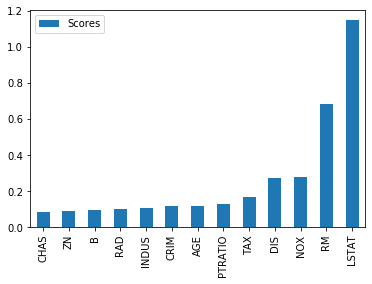

In [31]:
percent_diff_score = (a.mean(axis=0).sort_values() - gb2.mean()[0])/gb2.mean()[0]
display(percent_diff_score)
percent_diff_score_data = pd.DataFrame(percent_diff_score, columns=["Scores"])
percent_diff_score_data.plot.bar();

After running train-test-split 20 times, permuting each column 10 times, and retraining each training set, we see that LSTAT, RM, and NOX appear to be the 3 best features. However, we will replace NOX with DIS, since the later code reveals DIS is actually the third best feature.

In [33]:
#ALL VARIABLES GB2

num_iterations = 30
predictions_all_var = []
ytests_all_var = []
mses_all_var = []

for iteration in range(num_iterations):
    Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,test_size=0.10,shuffle=True)
    models_train = copy.deepcopy(models)
    
    model = models_train[1]
    
    m = model[1].fit(Xtrain, ytrain)
    predictions_all_var.append(m.predict(Xtest))
    ytests_all_var.append(ytest)
    mses_all_var.append(mean_squared_error(ytest, m.predict(Xtest)))
    

all_var_df = pd.DataFrame(mses_all_var, columns=["All Features"])

In [34]:
#SUBSET VARIABLES GB2

num_iterations = 30
predictions_subset = []
ytests_subset = []
mses_subset = []

for iteration in range(num_iterations):
    Xtrain, Xtest, ytrain, ytest = train_test_split(X[["DIS", "RM", "LSTAT"]],y,test_size=0.10,shuffle=True)
    models_train = copy.deepcopy(models)
    
    model = models_train[1]
    
    m = model[1].fit(Xtrain, ytrain)
    predictions_subset.append(m.predict(Xtest))
    ytests_subset.append(ytest)
    mses_subset.append(mean_squared_error(ytest, m.predict(Xtest)))
    

subset_df = pd.DataFrame(mses_subset, columns=["Subset Features"])

In [36]:
errors = all_var_df.join(subset_df, how="left")
errors.describe()

,All Features,Subset Features
count,30.000000,30.000000
mean,11.053123,18.302574
std,6.996503,8.013504
min,4.518106,8.023697
25%,7.202934,13.182885
50%,9.388140,16.025886
75%,12.325122,23.009161
max,40.723584,39.727169


In the subset features, we see a higher mean MSE and standard deviation of the MSE's after 30 iterations. At each quantile, the subset features yielded sligher higher MSE value estimates. Overall however, the subset features performs nearly just as well as using all features. 

**Exercise 9** Now what if I told you that Random Forest and other classifiers have built-in measures for feature importance. Run the following code and compare the feature importance scores. The calculation of these needs to be saved for another time and place, but the trees themselves contain information about feature importance based on the location in the tree a feature is most often selected.

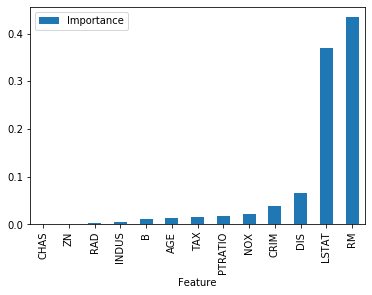

In [37]:
forest = RandomForestRegressor(n_estimators=500)
forest.fit(X,y)
importances = forest.feature_importances_
importances = pd.DataFrame({'Feature':X.columns,'Importance':importances})
importances.sort_values(by='Importance').set_index('Feature').plot.bar()

Scikit-learn best features testing reveals that RM, LSTAT, and DIS are the best features. 

**Implementation from scratch portion**: We are now going to implement two ensemble learning methods from scratch and see how our implementations compare to sklearn.

**Exercise 10** Implement a simple random forest classifier and compare the performance to one of the random forest classifiers above.

In [38]:
from sklearn.tree import DecisionTreeRegressor

def boostrap_sample(X, y, frac=0.3):
    Xy = X.copy()
    Xy[y.name] = y
    Xy_sample = Xy.sample(frac=frac,replace=True)
    
    return Xy.drop(y.name,axis=1),Xy[y.name]


def make_tree(X, y, m=None):
    if m is None:
        m = int(np.sqrt(X.shape[1]))
        
    nums = np.random.rand(X.shape[1])
    vs = pd.DataFrame({"num":nums})
    vs = vs.sort_values(by='num')
    features = vs.index
    Xf = X.iloc[:,features]
    
    return features, DecisionTreeRegressor(random_state=0).fit(Xf, y)


def make_trees(X, y, ntrees=100, m=None, frac=0.3):
    trees = []
    for i in range(ntrees):
        Xsample, ysample = boostrap_sample(X, y, frac=frac)
        trees.append(make_tree(Xsample, ysample, m=m))
        
    return trees


def make_prediction(trees, X):
    predictions = []
    tree_predictions = []
    for j in range(len(trees)):
        features = trees[j][0]
        tree = trees[j][1]
        tree_predictions.append(tree.predict(X.iloc[:,features])) 
    return tree_predictions
    
    
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.10, shuffle=True)
mses = []
for i in range(20):
    temp = []
    trees = make_trees(Xtrain, ytrain)
    predictions = make_prediction(trees, Xtest)
    for i in range(len(predictions)):
        temp.append(mean_squared_error(ytest, predictions[i]))
    mses.append(np.mean(temp))


In [39]:
our_mses = pd.DataFrame(mses, columns=["Our RF"])
our_mses.head()

,Our RF
0,21.659359
1,21.874916
2,21.181827
3,21.715788
4,21.824492


In [40]:
compare_rf_errors = rf1.join(our_mses, how="left")
compare_rf_errors.head()

,RF 1,Our RF
0,7.788218,21.659359
1,15.413025,21.874916
2,9.778086,21.181827
3,11.365300,21.715788
4,7.079514,21.824492


In [41]:
compare_rf_errors.describe()

,RF 1,Our RF
count,200.000000,20.000000
mean,10.924009,21.657684
std,5.065647,0.221101
min,3.784835,21.181827
25%,7.354933,21.499527
50%,9.377936,21.687574
75%,13.440044,21.808270
max,31.849355,22.106139


Our RF model gives much more precise scores in comparison to the scikit-learn random foresting model however, by the MSE values, our model is not as accurate. 

**Exercise 10** Implement gradient boosting from scratch using a mean squared error loss function. Compare the performance. I "boosted" 100 times. I've shown my validation graph. Every run is a little different, and it would definitely make this algorithm smarter if you stopped based on the validation graph.

In [42]:
def get_residuals(actual, predictions):
    return actual - predictions
   
def make_tree(X, y, m=None):
    Xresids = get_residuals(y, X["prediction"])
   
    if m is None:
        m = int(np.sqrt(X.shape[1]))
       
    nums = np.random.rand(X.shape[1])
    vs = pd.DataFrame({"num":nums})
    vs = vs.sort_values(by='num')
    features = vs.index
    Xf = X.iloc[:,features]
   
    return features, DecisionTreeRegressor(random_state=0).fit(Xf, Xresids)
 
def make_trees(X, y, ntrees=1, m=None, frac=0.3):
    trees = []
    for i in range(ntrees):
        trees.append(make_tree(X, y, m=m))
       
    return trees
 
def make_prediction(trees, X):
    predictions = []
    tree_predictions = []
    #for j in range(len(trees)):
    features = trees[0]
    tree = trees[1]
    return tree.predict(X.iloc[:,features])
 

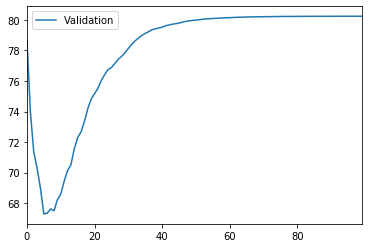

In [43]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.75, shuffle=True)
Xtrain, Xval, ytrain, yval = train_test_split(Xtrain, ytrain, test_size=0.75, shuffle=True)
 
Xtrain["prediction"] = ytrain.mean()
Xval["prediction"] = yval.mean()
 
mse_list = []
tree_list = []
for i in range(100):
    tree = make_tree(Xtrain, ytrain)
    tree_list.append(tree)
    predictions = make_prediction(tree, Xtrain)
    Xtrain["prediction"] = Xtrain["prediction"] + 0.1*predictions
    valpredictions = make_prediction(tree, Xval)
    Xval["prediction"] = Xval["prediction"] + 0.1*valpredictions
    mse1 = mean_squared_error(yval, Xval["prediction"])

    mse_list.append(mse1)
       
pd.DataFrame(mse_list, columns=["Validation"]).plot.line()

In [44]:
import warnings
warnings.filterwarnings('ignore')

minidx = pd.DataFrame(mse_list).idxmin()
minidx[0]
 
finaltree = tree_list[minidx[0]]
 
Xtest["prediction"] = ytest.mean()
predictions = make_prediction(finaltree, Xtest)
mean_squared_error(ytest, Xtest["prediction"])

85.32527777008309